In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import requests
import zipfile
import io
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
import json



# Zebra Activity Analysis

This script investigates the correlation between weather conditions and zebra activity using Snapshot Serengeti camera trap data and POWER weather data.



## 0. Setup and Data Acquisition

We will automatically download and extract the Snapshot Serengeti dataset if it's not present.

### Datasets:
1. Swanson, A., Kosmala, M., Lintott, C., Simpson, R., Smith, A., & Packer, C. (2015). Snapshot Serengeti, high-frequency annotated camera trap images of 40 mammalian species in an African savanna. Scientific Data, 2, 150026. https://doi.org/10.1038/sdata.2015.26
2. NASA POWER Project. (2025). POWER Single Point Data Access (Version 2.0). NASA Langley Research Center. Accessed December 11, 2025, from https://power.larc.nasa.gov/




In [ ]:
!mkdir -p data && wget -O data/temp.zip "https://storage.googleapis.com/public-datasets-lila/snapshotserengeti-v-2-0/SnapshotSerengeti_S1-11_v2_1.csv.zip" && unzip -o data/temp.zip -d data && rm data/temp.zip
!wget -O POWER_Point_Hourly_20100101_20151231_002d45S_034d83E_LST.csv "https://gist.githubusercontent.com/QuellaMC/45521196e3e45a615bf0b159b1f3bb1b/raw/6bee6bf6cafec30991e98f1e74b8439e9d0b1b35/POWER_Point_Hourly_20100101_20151231_002d45S_034d83E_LST.csv"

--2025-12-10 20:03:00--  https://storage.googleapis.com/public-datasets-lila/snapshotserengeti-v-2-0/SnapshotSerengeti_S1-11_v2_1.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.207, 108.177.96.207, 108.177.119.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101736434 (97M) [application/x-zip-compressed]
Saving to: ‘data/temp.zip’

data/temp.zip       100%[===================>]  97.02M  31.3MB/s    in 3.1s    

2025-12-10 20:03:04 (31.3 MB/s) - ‘data/temp.zip’ saved [101736434/101736434]

Archive:  data/temp.zip
  inflating: data/SnapshotSerengeti_v2_1_annotations.csv  
  inflating: data/SnapshotSerengeti_v2_1_images.csv  
--2025-12-10 20:03:08--  https://gist.githubusercontent.com/QuellaMC/45521196e3e45a615bf0b159b1f3bb1b/raw/6bee6bf6cafec30991e98f1e74b8439e9d0b1b35/POWER_Point_Hourly_20100101_20151231_002d45S_034d83E_LST.csv
Resolving gist.gi

In [ ]:
best_model_result = None

## 1. Load and Clean Weather Data

We will load the POWER weather data, parse the dates, and aggregate it to a daily level.



In [ ]:
def load_weather_data(filepath):
    """
    Loads and cleans the weather data.
    """
    print(f"Loading weather data from {filepath}...")

    df_weather = pd.read_csv(filepath, header=12)

    # Create a datetime column
    df_weather['Date'] = pd.to_datetime(df_weather[['YEAR', 'MO', 'DY', 'HR']].rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day', 'HR': 'hour'}))

    # Rename columns for clarity
    df_weather = df_weather.rename(columns={
        'T2M': 'Temperature_C',
        'PRECTOTCORR': 'Precipitation_mm_hr',
        'WS2M': 'WindSpeed_m_s',
        'WD2M': 'WindDirection_deg'
    })

    return df_weather

def check_data_quality(df, name="Dataset"):
    """
    Performs basic data quality checks.
    """
    print(f"--- Data Quality Check: {name} ---")
    print(f"Shape: {df.shape}")

    # Missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("Missing values per column:")
        print(missing[missing > 0])
    else:
        print("No missing values found.")

    # Duplicates
    duplicates = df.duplicated().sum()
    print(f"Duplicate rows: {duplicates}")

    print("-" * 30)

weather_file = 'POWER_Point_Hourly_20100101_20151231_002d45S_034d83E_LST.csv'
if os.path.exists(weather_file):
    df_weather_hourly = load_weather_data(weather_file)
    check_data_quality(df_weather_hourly, "Hourly Weather Data")
    print("Weather data loaded. Head:")
    print(df_weather_hourly.head())
else:
    print(f"Weather file {weather_file} not found.")



Loading weather data from POWER_Point_Hourly_20100101_20151231_002d45S_034d83E_LST.csv...
--- Data Quality Check: Hourly Weather Data ---
Shape: (52584, 9)
No missing values found.
Duplicate rows: 0
------------------------------
Weather data loaded. Head:
   YEAR  MO  DY  HR  Temperature_C  Precipitation_mm_hr  WindSpeed_m_s  \
0  2010   1   1   0          16.74                 1.64           0.75   
1  2010   1   1   1          16.16                 2.50           0.80   
2  2010   1   1   2          15.63                 3.73           0.86   
3  2010   1   1   3          15.14                 4.76           0.90   
4  2010   1   1   4          14.68                 4.24           0.94   

   WindDirection_deg                Date  
0              115.2 2010-01-01 00:00:00  
1              106.6 2010-01-01 01:00:00  
2              100.8 2010-01-01 02:00:00  
3              100.9 2010-01-01 03:00:00  
4              100.5 2010-01-01 04:00:00  


### Aggregate Weather Data to Daily

Since we want to analyze daily zebra activity, we should aggregate weather data to daily metrics.



In [ ]:
def aggregate_weather_daily(df_hourly):
    """
    Aggregates hourly weather data to daily.
    """
    # Create a Date column (without time) for grouping
    df_hourly['Date_Day'] = df_hourly['Date'].dt.date

    daily_agg = df_hourly.groupby('Date_Day').agg({
        'Temperature_C': ['mean', 'min', 'max'],
        'Precipitation_mm_hr': 'sum', # Total daily precipitation
        'WindSpeed_m_s': 'mean'
    })

    # Flatten MultiIndex columns
    daily_agg.columns = ['_'.join(col).strip() for col in daily_agg.columns.values]
    daily_agg = daily_agg.rename(columns={
        'Precipitation_mm_hr_sum': 'Precipitation_Total_mm'
    })

    daily_agg = daily_agg.reset_index()
    daily_agg['Date_Day'] = pd.to_datetime(daily_agg['Date_Day'])

    return daily_agg


def add_climatology_anomalies(df):
    df = df.copy()
    df['DayOfYear'] = df['Date_Day'].dt.dayofyear

    clim = df.groupby('DayOfYear')[['Temperature_C_mean','Precipitation_Total_mm']].mean()
    clim.columns = ['Temp_clim_mean', 'Precip_clim_mean']

    df = df.merge(clim, on='DayOfYear', how='left')
    df['Temp_anom'] = df['Temperature_C_mean'] - df['Temp_clim_mean']
    df['Precip_anom'] = df['Precipitation_Total_mm'] - df['Precip_clim_mean']
    return df

def add_weather_features(df_weather_daily):
    """
    Adds lagged and rolling weather features to the daily weather dataframe.
    """
    df = df_weather_daily.sort_values('Date_Day').copy()

    # Add Climatology and Anomalies
    df = add_climatology_anomalies(df)

    # Lags
    for col in ['Temperature_C_mean', 'Precipitation_Total_mm', 'WindSpeed_m_s_mean']:
        for lag in [1, 2, 3]:
            df[f'{col}_Lag{lag}'] = df[col].shift(lag)

    # Rolling
    for col in ['Temperature_C_mean', 'Precipitation_Total_mm']:
        df[f'{col}_Roll3'] = df[col].rolling(window=3).mean()
        df[f'{col}_Roll7'] = df[col].rolling(window=7).mean()

    # Seasonality
    df['Month'] = df['Date_Day'].dt.month
    df['Is_Wet_Season'] = df['Month'].isin([11,12,1,2,3,4,5]).astype(int)

    # Cyclical Seasonality
    # DayOfYear is already added in add_climatology_anomalies
    df['DOY_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
    df['DOY_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)

    # Interaction
    df['Temp_x_Precip'] = df['Temperature_C_mean'] * df['Precipitation_Total_mm']

    return df

df_weather_daily = aggregate_weather_daily(df_weather_hourly)
df_weather_daily = add_weather_features(df_weather_daily)
print("Daily weather data aggregated and features added. Head:")
print(df_weather_daily.head())



Daily weather data aggregated and features added. Head:
    Date_Day  Temperature_C_mean  Temperature_C_min  Temperature_C_max  \
0 2010-01-01           19.434583              14.53              24.38   
1 2010-01-02           17.096667              14.49              20.35   
2 2010-01-03           18.898750              13.88              23.92   
3 2010-01-04           18.442917              15.31              22.63   
4 2010-01-05           19.288750              14.28              24.37   

   Precipitation_Total_mm  WindSpeed_m_s_mean  DayOfYear  Temp_clim_mean  \
0                  298.16            1.109167          1       19.537917   
1                  323.96            2.330417          2       19.010417   
2                  121.31            0.923750          3       19.511806   
3                  528.79            1.377917          4       19.466319   
4                  227.22            1.487083          5       19.985069   

   Precip_clim_mean  Temp_anom  ...  WindS

## 2. Load and Clean Camera Trap Data

We will load the Snapshot Serengeti annotations, filter for zebras, and calculate daily activity metrics.



In [ ]:
def load_zebra_data(filepath):
    """
    Loads and cleans the camera trap data, filtering for zebras.
    """
    print(f"Loading camera trap data from {filepath}...")
    # Read only necessary columns to save memory
    cols = ['capture_id', 'question__species', 'question__count_median', 'capture_date_local']
    df = pd.read_csv(filepath, usecols=cols)

    # Filter for zebras
    df_zebra = df[df['question__species'] == 'zebra'].copy()

    # Parse date
    df_zebra['Date'] = pd.to_datetime(df_zebra['capture_date_local'])
    df_zebra['Date_Day'] = df_zebra['Date'].dt.date

    # Clean count column
    def clean_count(val):
        if pd.isna(val):
            return 1 # Default to 1 if missing
        val = str(val)
        if val == '11-50':
            return 30 # Midpoint
        if val == '51+':
            return 60 # Arbitrary estimate
        try:
            return float(val)
        except ValueError:
            return 1 # Fallback

    df_zebra['question__count_median'] = df_zebra['question__count_median'].apply(clean_count)

    return df_zebra

def aggregate_zebra_daily(df_zebra):
    """
    Aggregates zebra data to daily activity metrics.
    """
    daily_activity = df_zebra.groupby('Date_Day').agg({
        'capture_id': 'count', # Number of events
        'question__count_median': 'sum' # Total estimated zebras
    }).rename(columns={
        'capture_id': 'Zebra_Event_Count',
        'question__count_median': 'Zebra_Total_Count'
    })

    daily_activity = daily_activity.reset_index()
    daily_activity['Date_Day'] = pd.to_datetime(daily_activity['Date_Day'])

    return daily_activity

annotations_file = 'data/SnapshotSerengeti_v2_1_annotations.csv'
if os.path.exists(annotations_file):
    df_zebra_events = load_zebra_data(annotations_file)
    check_data_quality(df_zebra_events, "Zebra Events Data")

    # Check for outliers in count
    print("Zebra Count Statistics:")
    print(df_zebra_events['question__count_median'].describe())

    df_zebra_daily = aggregate_zebra_daily(df_zebra_events)
    print("Daily zebra activity aggregated. Head:")
    print(df_zebra_daily.head())
else:
    print(f"Annotations file {annotations_file} not found.")



Loading camera trap data from data/SnapshotSerengeti_v2_1_annotations.csv...
--- Data Quality Check: Zebra Events Data ---
Shape: (139214, 6)
No missing values found.
Duplicate rows: 0
------------------------------
Zebra Count Statistics:
count    139214.000000
mean          3.917946
std           6.036722
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          60.000000
Name: question__count_median, dtype: float64
Daily zebra activity aggregated. Head:
    Date_Day  Zebra_Event_Count  Zebra_Total_Count
0 2010-07-21                  3                5.0
1 2010-07-22                  3                6.0
2 2010-07-23                  1                1.0
3 2010-07-24                  1                1.0
4 2010-07-26                  2               11.0


## 3. Merge and Analyze

We will merge the daily weather and zebra datasets and investigate correlations.



Merged data shape: (2191, 31)
Correlation Matrix:
                        Zebra_Event_Count  Zebra_Total_Count  \
Zebra_Event_Count                1.000000           0.906243   
Zebra_Total_Count                0.906243           1.000000   
Temperature_C_mean               0.103731           0.063327   
Temperature_C_min                0.056922           0.059946   
Temperature_C_max                0.121484           0.069417   
Precipitation_Total_mm          -0.004069           0.019529   
WindSpeed_m_s_mean               0.066967           0.047843   

                        Temperature_C_mean  Temperature_C_min  \
Zebra_Event_Count                 0.103731           0.056922   
Zebra_Total_Count                 0.063327           0.059946   
Temperature_C_mean                1.000000           0.405192   
Temperature_C_min                 0.405192           1.000000   
Temperature_C_max                 0.856419          -0.044516   
Precipitation_Total_mm           -0.269575     

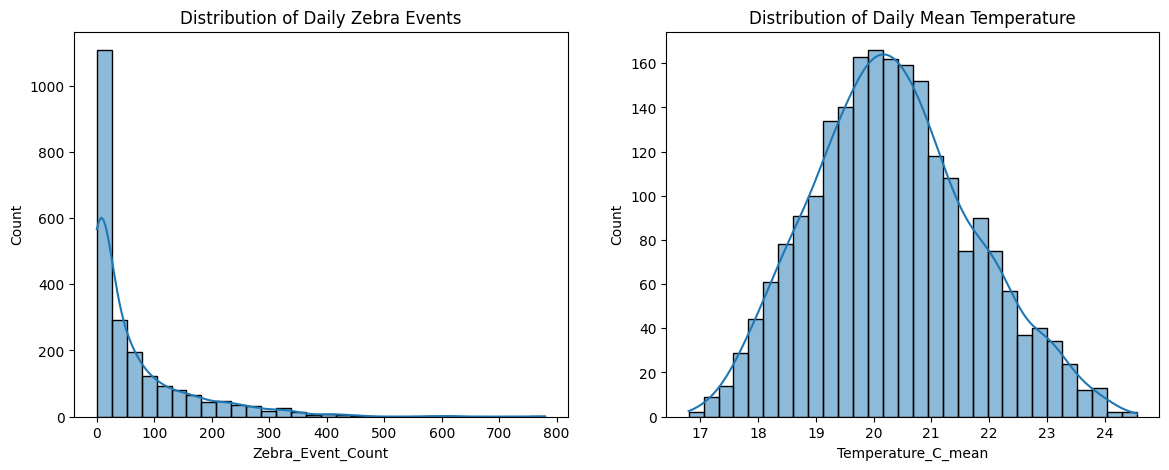

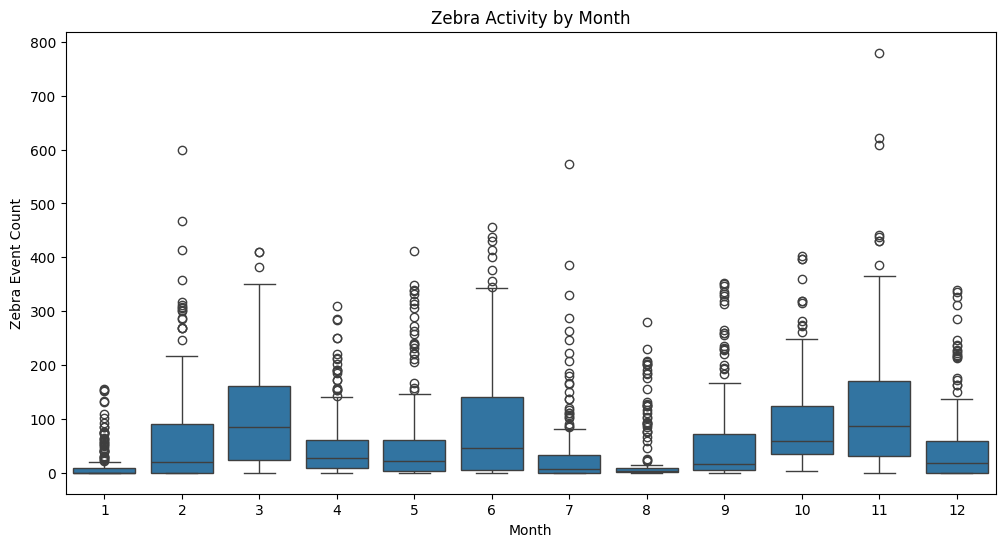

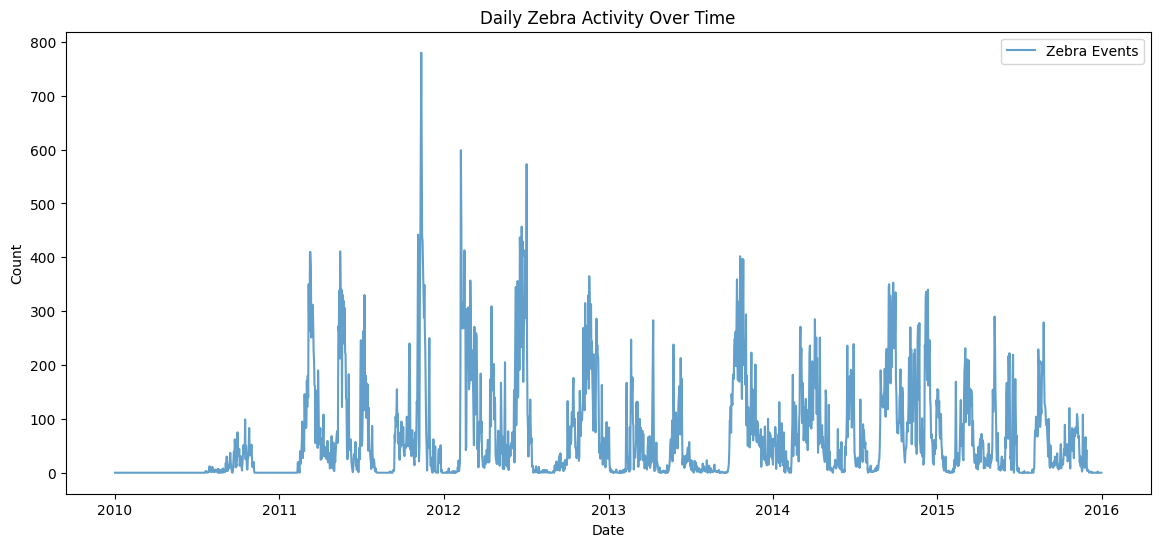

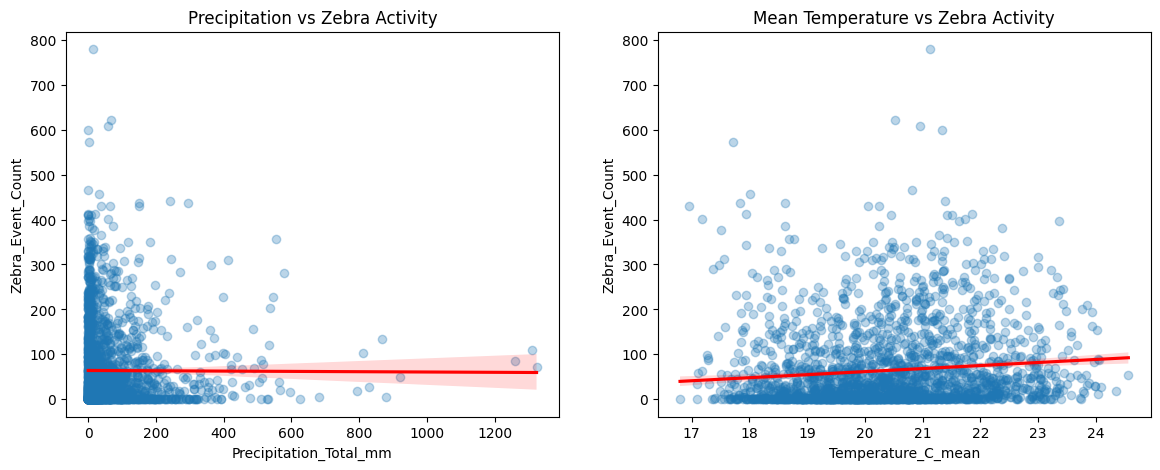

Analysis complete.


In [ ]:
def analyze_correlation(df_weather, df_zebra):
    """
    Merges datasets and calculates correlations.
    """
    # Merge on Date_Day
    df_merged = pd.merge(df_weather, df_zebra, on='Date_Day', how='left')

    # Fill NaNs in zebra counts with 0
    df_merged['Zebra_Event_Count'] = df_merged['Zebra_Event_Count'].fillna(0)
    df_merged['Zebra_Total_Count'] = df_merged['Zebra_Total_Count'].fillna(0)

    print(f"Merged data shape: {df_merged.shape}")

    # Calculate correlation matrix
    cols_to_corr = [
        'Zebra_Event_Count', 'Zebra_Total_Count',
        'Temperature_C_mean', 'Temperature_C_min', 'Temperature_C_max',
        'Precipitation_Total_mm', 'WindSpeed_m_s_mean'
    ]

    corr_matrix = df_merged[cols_to_corr].corr()

    print("Correlation Matrix:")
    print(corr_matrix)

    return df_merged, corr_matrix

def plot_results(df_merged):
    """
    Generates plots for the analysis.
    """
    # 1. Histograms
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df_merged['Zebra_Event_Count'], bins=30, kde=True)
    plt.title('Distribution of Daily Zebra Events')

    plt.subplot(1, 2, 2)
    sns.histplot(df_merged['Temperature_C_mean'], bins=30, kde=True)
    plt.title('Distribution of Daily Mean Temperature')
    plt.show()

    # 2. Box Plots by Month
    df_merged['Month'] = df_merged['Date_Day'].dt.month
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_merged, x='Month', y='Zebra_Event_Count')
    plt.title('Zebra Activity by Month')
    plt.xlabel('Month')
    plt.ylabel('Zebra Event Count')
    plt.show()

    # 3. Time Series
    plt.figure(figsize=(14, 6))
    plt.plot(df_merged['Date_Day'], df_merged['Zebra_Event_Count'], label='Zebra Events', alpha=0.7)
    plt.title('Daily Zebra Activity Over Time')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    # 4. Scatter Plots with Regression
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    sns.regplot(data=df_merged, x='Precipitation_Total_mm', y='Zebra_Event_Count', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title('Precipitation vs Zebra Activity')

    plt.subplot(1, 2, 2)
    sns.regplot(data=df_merged, x='Temperature_C_mean', y='Zebra_Event_Count', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title('Mean Temperature vs Zebra Activity')
    plt.show()

df_merged, corr_matrix = analyze_correlation(df_weather_daily, df_zebra_daily)
plot_results(df_merged)
print("Analysis complete.")



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def generate_report_eda_plots(df):
    print("--- Generating High-Quality EDA Plots for Report ---")

    sns.set_style("whitegrid")

    # Zebras follow Rain
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Date (2010-2013)', fontsize=12)
    ax1.set_ylabel('Daily Precipitation (mm)', color=color, fontsize=12)
    # Rain Rolling mean
    ax1.plot(df['Date_Day'], df['Precipitation_Total_mm'].rolling(14).mean(),
             color=color, alpha=0.6, label='Rainfall (14-day Avg)')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:brown'
    ax2.set_ylabel('Zebra Event Count', color=color, fontsize=12)
    # Zebras Rolling mean
    ax2.plot(df['Date_Day'], df['Zebra_Event_Count'].rolling(14).mean(),
             color=color, linewidth=2, label='Zebra Activity (14-day Avg)')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Biological Correlation: Zebra Activity vs. Rainfall Seasons', fontsize=14)
    fig.tight_layout()
    plt.savefig('Fig_1_Seasonality.png', dpi=300)
    plt.show()
    print("Saved 'Fig_1_Seasonality.png'")

    # Feature Correlations
    plt.figure(figsize=(10, 8))

    corr_cols = [
        'Zebra_Event_Count',
        'Temperature_C_mean', 'Precipitation_Total_mm',
        'WindSpeed_m_s_mean', 'DOY_cos', 'Temp_anom'
    ]

    corr = df[corr_cols].corr()

    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title('Feature Correlation Matrix', fontsize=14)
    plt.tight_layout()
    plt.savefig('Fig_2_Correlations.png', dpi=300)
    plt.show()
    print("Saved 'Fig_2_Correlations.png'")

    # Target Class Balance
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x='Is_High_Activity', data=df, palette='viridis')
    plt.title('Target Class Distribution (0=Low, 1=High)', fontsize=14)
    plt.xlabel('Activity Class')
    plt.ylabel('Days Count')

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    plt.tight_layout()
    plt.savefig('Fig_3_ClassBalance.png', dpi=300)
    plt.show()
    print("Saved 'Fig_3_ClassBalance.png'")

generate_report_eda_plots(df_modeled)

## 4. Modeling and Evaluation

We will train Logistic Regression and Random Forest models to predict high zebra activity.



Target Threshold (Median Event Count): 25.0
Class Balance:
Is_High_Activity
0    0.505705
1    0.494295
Name: proportion, dtype: float64
Train shape: (1748, 25), Test shape: (437, 25)

--- Starting Model Tuning & Training (Time-Based Split) ---

Tuning Logistic Regression...
Best LR Params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

Tuning Random Forest...
Best RF Params: {'n_estimators': 100, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 5}

Tuning Gradient Boosting...
Best GBM Params: {'subsample': 0.6, 'n_estimators': 100, 'min_samples_leaf': 5, 'max_depth': 2, 'learning_rate': 0.01}
PyTorch Class Weight (pos_weight): 1.09

Starting Hyperparameter Tuning for PyTorch Model...
Best PyTorch Params: {'hidden_layers': [64, 64, 32], 'dropout_rate': 0.5, 'learning_rate': 0.001, 'epochs': 50}
Best PyTorch Validation AUC: 0.6867

Logistic Regression Results:
F1-Score: 0.6419
AUC-ROC: 0.6069

Random Forest Results:
F1-Score: 0.6433
AUC-ROC: 0.6595

Gradient Boosting Resu

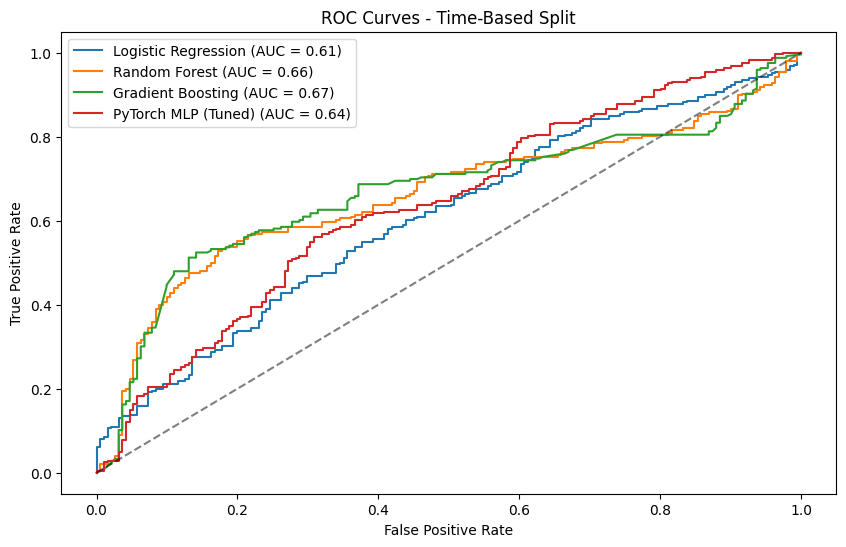


Feature importances (Gradient Boosting):


/tmp/ipython-input-3236858034.py:240: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp, x='Importance', y='Feature', palette='viridis')


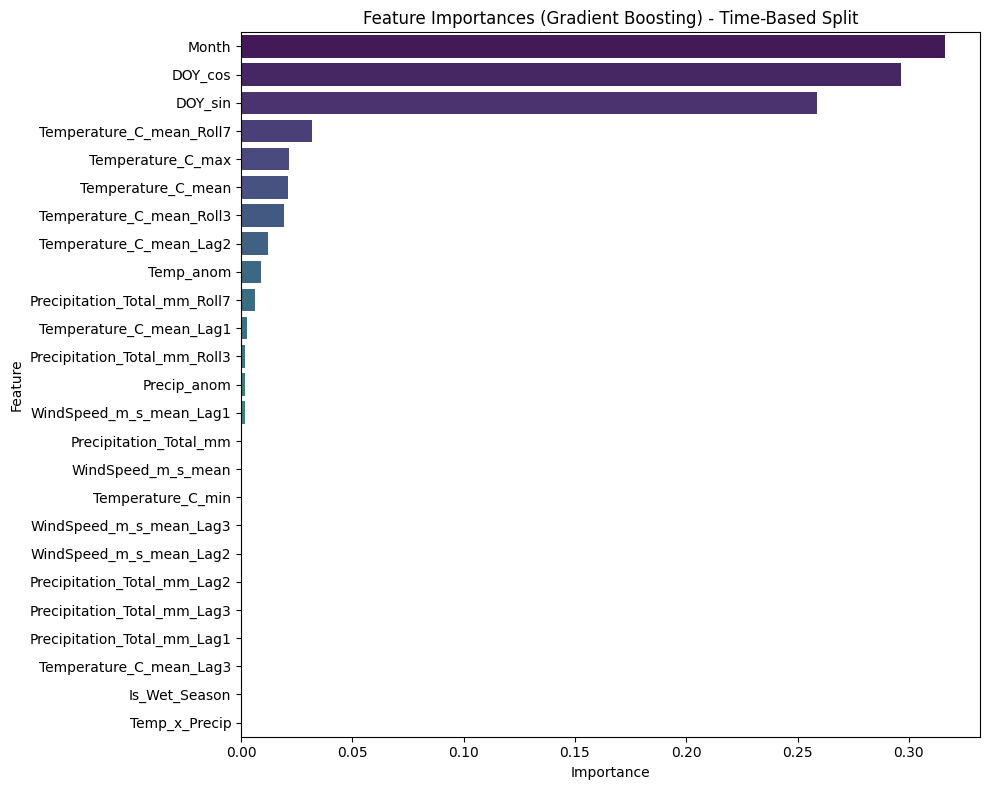

In [ ]:
def feature_engineering(df, threshold=None):
    """
    Creates target variable. Features are assumed to be pre-computed.
    """
    df_model = df.copy()

    # Target Variable: Is_High_Activity (Binary)
    if threshold is None:
        threshold = df_model['Zebra_Event_Count'].median()

    df_model['Is_High_Activity'] = (df_model['Zebra_Event_Count'] > threshold).astype(int)
    print(f"Target Threshold (Median Event Count): {threshold}")
    print(f"Class Balance:\n{df_model['Is_High_Activity'].value_counts(normalize=True)}")

    # Drop rows with NaNs
    df_model = df_model.dropna()

    return df_model, threshold

def tune_and_train_models(X_train, y_train, X_test, y_test, label_suffix=""):
    """
    Tunes, trains, and evaluates 4 models: LR, RF, GBM, MLP.
    Returns a dictionary of results.
    """
    print(f"\n--- Starting Model Tuning & Training ({label_suffix}) ---")

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 1. Logistic Regression
    print("\nTuning Logistic Regression...")
    lr_param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
    lr = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced') # <--- Added class_weight
    lr_search = GridSearchCV(lr, lr_param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
    lr_search.fit(X_train_scaled, y_train)

    best_lr = lr_search.best_estimator_
    y_pred_lr = best_lr.predict(X_test_scaled)
    y_prob_lr = best_lr.predict_proba(X_test_scaled)[:, 1]
    print(f"Best LR Params: {lr_search.best_params_}")

    # 2. Random Forest
    print("\nTuning Random Forest...")
    rf_param_dist = {
        'n_estimators': [100, 200, 400],
        'max_depth': [None, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 10],
        'max_features': ['sqrt', 'log2']
    }
    rf = RandomForestClassifier(random_state=42, class_weight='balanced') # <--- Added class_weight
    rf_search = RandomizedSearchCV(rf, rf_param_dist, n_iter=20, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)
    rf_search.fit(X_train, y_train)

    best_rf = rf_search.best_estimator_
    y_pred_rf = best_rf.predict(X_test)
    y_prob_rf = best_rf.predict_proba(X_test)[:, 1]
    print(f"Best RF Params: {rf_search.best_params_}")
    global best_model_result
    best_model_result = best_rf

    # 3. Gradient Boosting
    print("\nTuning Gradient Boosting...")
    gb_param_dist = {
        'n_estimators': [100, 200, 400],
        'max_depth': [2, 3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'min_samples_leaf': [1, 5, 10]
    }

    gb = GradientBoostingClassifier(random_state=42)
    gb_search = RandomizedSearchCV(
        gb, param_distributions=gb_param_dist,
        n_iter=20,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42
    )
    gb_search.fit(X_train, y_train)

    best_gb = gb_search.best_estimator_
    y_pred_gb = best_gb.predict(X_test)
    y_prob_gb = best_gb.predict_proba(X_test)[:, 1]
    print(f"Best GBM Params: {gb_search.best_params_}")

    # 4. Advanced PyTorch MLP
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

    # Internal Validation Split for Tuning
    split_idx_inner = int(len(X_train_tensor) * 0.8)
    X_train_inner = X_train_tensor[:split_idx_inner]
    y_train_inner = y_train_tensor[:split_idx_inner]
    X_val_inner = X_train_tensor[split_idx_inner:]
    y_val_inner = y_train_tensor[split_idx_inner:]

    # Calculate Weights for PyTorch
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    pos_weight_value = n_neg / n_pos
    pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32)
    print(f"PyTorch Class Weight (pos_weight): {pos_weight_value:.2f}")

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    class AdvancedZebraMLP(nn.Module):
        def __init__(self, input_dim, hidden_layers=[64, 32], dropout_rate=0.2):
            super(AdvancedZebraMLP, self).__init__()
            layers = []
            in_dim = input_dim
            for h_dim in hidden_layers:
                layers.append(nn.Linear(in_dim, h_dim))
                layers.append(nn.BatchNorm1d(h_dim))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout_rate))
                in_dim = h_dim
            layers.append(nn.Linear(in_dim, 1))
            self.model = nn.Sequential(*layers)

        def forward(self, x):
            return self.model(x)

    # Tuning
    print("\nStarting Hyperparameter Tuning for PyTorch Model...")
    param_grid = {
        'hidden_layers': [[64, 32], [128, 64], [64, 64, 32]],
        'dropout_rate': [0.2, 0.5],
        'learning_rate': [0.01, 0.001],
        'epochs': [50, 100]
    }

    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    best_auc = 0
    best_params = {}

    for i, params in enumerate(combinations):
        torch.manual_seed(42)
        model = AdvancedZebraMLP(X_train_scaled.shape[1], hidden_layers=params['hidden_layers'], dropout_rate=params['dropout_rate'])

        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        # Training on Inner Train
        model.train()
        for epoch in range(params['epochs']):
            optimizer.zero_grad()
            outputs = model(X_train_inner)
            loss = criterion(outputs, y_train_inner)
            loss.backward()
            optimizer.step()

        # Validation on Inner Val
        model.eval()
        with torch.no_grad():
            # Added Sigmoid for AUC calculation
            y_prob = torch.sigmoid(model(X_val_inner)).numpy().flatten()
            auc = roc_auc_score(y_val_inner, y_prob)

        if auc > best_auc:
            best_auc = auc
            best_params = params

    print(f"Best PyTorch Params: {best_params}")
    print(f"Best PyTorch Validation AUC: {best_auc:.4f}")

    # Retrain Best Model on Full Training Set
    best_model = AdvancedZebraMLP(X_train_scaled.shape[1], hidden_layers=best_params['hidden_layers'], dropout_rate=best_params['dropout_rate'])
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])

    best_model.train()
    for epoch in range(best_params['epochs']):
        optimizer.zero_grad()
        outputs = best_model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Final Prediction with Best Model
    best_model.eval()
    with torch.no_grad():
        # Added Sigmoid for final prediction
        y_prob_mlp = torch.sigmoid(best_model(X_test_tensor)).numpy().flatten()
        y_pred_mlp = (y_prob_mlp > 0.5).astype(int)

    # Evaluation
    results = {}
    models = [
        ('Logistic Regression', y_pred_lr, y_prob_lr),
        ('Random Forest', y_pred_rf, y_prob_rf),
        ('Gradient Boosting', y_pred_gb, y_prob_gb),
        ('PyTorch MLP (Tuned)', y_pred_mlp, y_prob_mlp)
    ]

    for name, y_pred, y_prob in models:
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        results[name] = {'F1': f1, 'AUC': auc}
        print(f"\n{name} Results:")
        print(f"F1-Score: {f1:.4f}")
        print(f"AUC-ROC: {auc:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(10, 6))
    for name, y_pred, y_prob in models:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["AUC"]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {label_suffix}')
    plt.legend()
    plt.show()

    print("\nFeature importances (Gradient Boosting):")
    importances = best_gb.feature_importances_
    feature_names = X_train.columns

    # Create DataFrame for plotting
    df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    df_imp = df_imp.sort_values('Importance', ascending=False)

    # Feature Importances
    plt.figure(figsize=(10, 8))
    sns.barplot(data=df_imp, x='Importance', y='Feature', palette='viridis')
    plt.title(f'Feature Importances (Gradient Boosting) - {label_suffix}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return results

def train_and_evaluate(df):
    """
    Trains models and evaluates them using time-based split.
    """
    # Features and Target
    feature_cols = [
        'Temperature_C_mean', 'Temperature_C_min', 'Temperature_C_max',
        'Precipitation_Total_mm', 'WindSpeed_m_s_mean',
        'Temp_anom', 'Precip_anom',
        'Temperature_C_mean_Lag1', 'Temperature_C_mean_Lag2', 'Temperature_C_mean_Lag3',
        'Precipitation_Total_mm_Lag1', 'Precipitation_Total_mm_Lag2', 'Precipitation_Total_mm_Lag3',
        'WindSpeed_m_s_mean_Lag1', 'WindSpeed_m_s_mean_Lag2', 'WindSpeed_m_s_mean_Lag3',
        'Month', 'Is_Wet_Season', 'DOY_sin', 'DOY_cos',
        'Temperature_C_mean_Roll3', 'Temperature_C_mean_Roll7',
        'Precipitation_Total_mm_Roll3', 'Precipitation_Total_mm_Roll7',
        'Temp_x_Precip'
    ]
    target_col = 'Is_High_Activity'

    X = df[feature_cols]
    y = df[target_col]

    # Time-based Split (80% train, 20% test)
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    return tune_and_train_models(X_train, y_train, X_test, y_test, label_suffix="Time-Based Split")


df_modeled, threshold = feature_engineering(df_merged)
model_results = train_and_evaluate(df_modeled)



## 5. Analysis with Official Splits

We will now use the official Snapshot Serengeti splits (Train/Val) to split the data spatially by site.



In [ ]:
!wget -O data/SnapshotSerengetiSplits_v0.json "https://storage.googleapis.com/public-datasets-lila/snapshotserengeti-v-2-0/SnapshotSerengetiSplits_v0.json"

--2025-12-10 20:04:08--  https://storage.googleapis.com/public-datasets-lila/snapshotserengeti-v-2-0/SnapshotSerengetiSplits_v0.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.207, 108.177.96.207, 108.177.119.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4734 (4.6K) [application/json]
Saving to: ‘data/SnapshotSerengetiSplits_v0.json’

data/SnapshotSereng 100%[===================>]   4.62K  --.-KB/s    in 0s      

2025-12-10 20:04:09 (67.5 MB/s) - ‘data/SnapshotSerengetiSplits_v0.json’ saved [4734/4734]




--- Running Analysis with Official Splits ---
Train sites: 179, Val (Test) sites: 46
Loading camera trap data from data/SnapshotSerengeti_v2_1_annotations.csv...
Train Events: 105181, Test Events: 34033
Target Threshold (Median Event Count): 34.0
Class Balance:
Is_High_Activity
0    0.503895
1    0.496105
Name: proportion, dtype: float64
Target Threshold (Median Event Count): 34.0
Class Balance:
Is_High_Activity
0    0.777147
1    0.222853
Name: proportion, dtype: float64
Train Set Shape: (1669, 32)
Test Set Shape: (1409, 32)

--- Starting Model Tuning & Training (Official Split) ---

Tuning Logistic Regression...
Best LR Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Tuning Random Forest...
Best RF Params: {'n_estimators': 200, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5}

Tuning Gradient Boosting...
Best GBM Params: {'subsample': 0.6, 'n_estimators': 100, 'min_samples_leaf': 5, 'max_depth': 2, 'learning_rate': 0.01}
PyTorch Class Weight (pos_weight): 1.

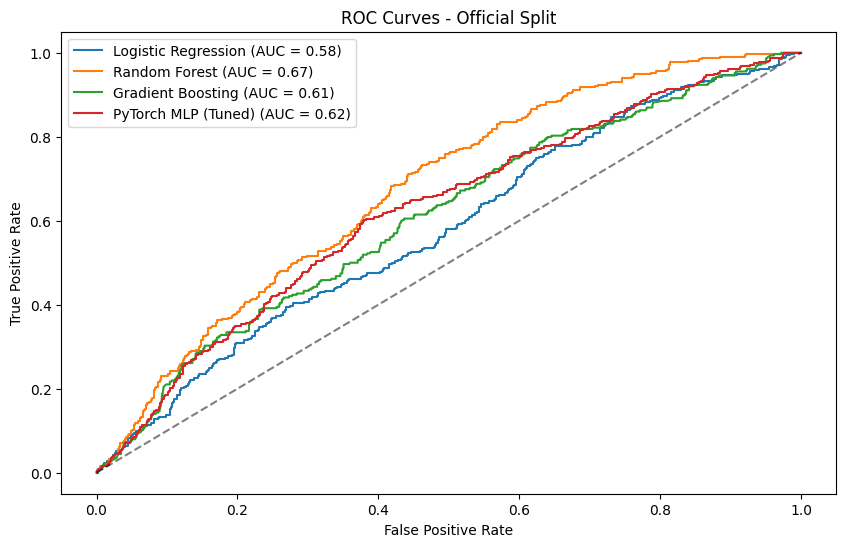


Feature importances (Gradient Boosting):


/tmp/ipython-input-3236858034.py:240: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp, x='Importance', y='Feature', palette='viridis')


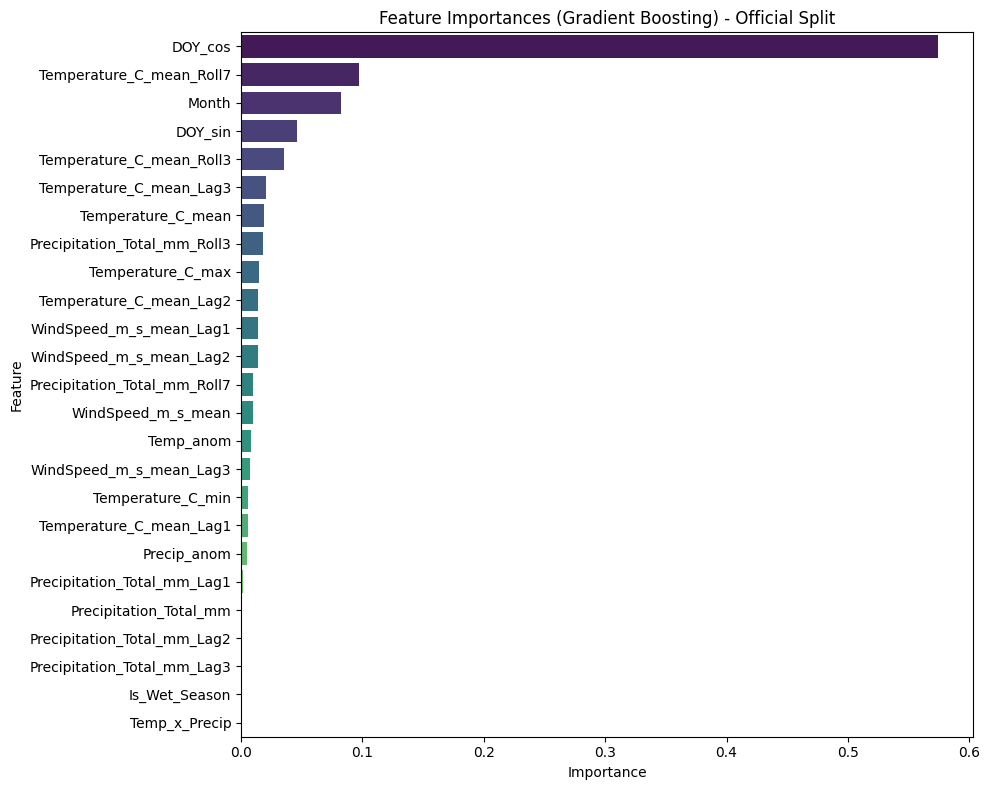


--- Comparing Splits ---


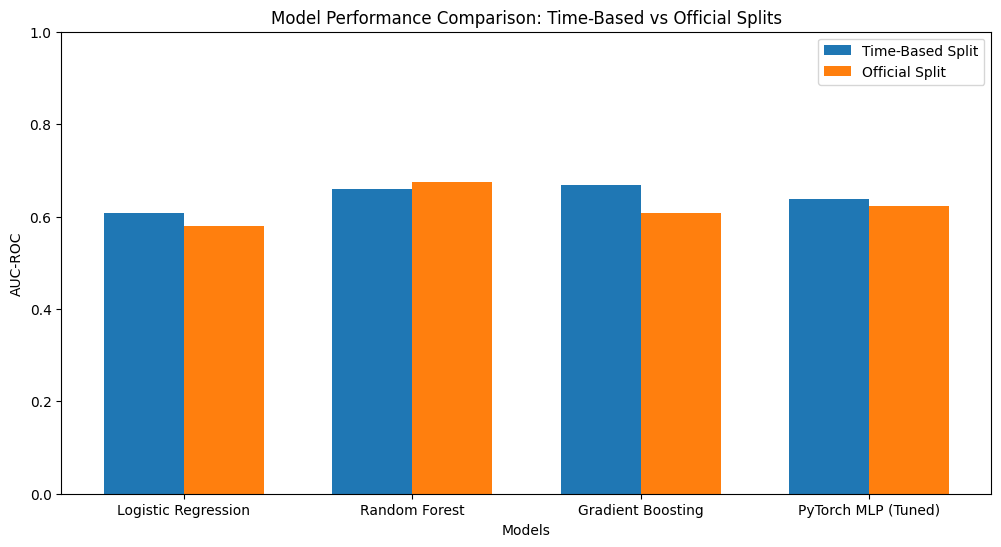

In [ ]:
def parse_site_id(capture_id):
    # capture_id format: season#site#event (e.g., S1#B03#1)
    try:
        return capture_id.split('#')[1]
    except:
        return None

def run_official_split_analysis(annotations_path, splits_path, df_weather_daily, model_results_time_based=None):
    print("\n--- Running Analysis with Official Splits ---")

    # Load Splits
    with open(splits_path, 'r') as f:
        splits = json.load(f)

    train_sites = set(splits['splits']['train'])
    val_sites = set(splits['splits']['val'])
    print(f"Train sites: {len(train_sites)}, Val (Test) sites: {len(val_sites)}")

    # Load and Split Zebra Data
    df_zebra = load_zebra_data(annotations_path)
    df_zebra['site_id'] = df_zebra['capture_id'].apply(parse_site_id)

    # Filter
    df_train_events = df_zebra[df_zebra['site_id'].isin(train_sites)].copy()
    df_test_events = df_zebra[df_zebra['site_id'].isin(val_sites)].copy()

    print(f"Train Events: {len(df_train_events)}, Test Events: {len(df_test_events)}")

    # Aggregate Daily
    df_train_daily = aggregate_zebra_daily(df_train_events)
    df_test_daily = aggregate_zebra_daily(df_test_events)

    # Merge with Weather
    df_train_merged = pd.merge(df_weather_daily, df_train_daily, on='Date_Day', how='left')
    df_test_merged = pd.merge(df_weather_daily, df_test_daily, on='Date_Day', how='left')

    # Fill NaNs
    df_train_merged['Zebra_Event_Count'] = df_train_merged['Zebra_Event_Count'].fillna(0)
    df_test_merged['Zebra_Event_Count'] = df_test_merged['Zebra_Event_Count'].fillna(0)

    # Drop NaNs
    df_train_merged = df_train_merged.dropna()
    df_test_merged = df_test_merged.dropna()

    # Feature Engineering
    df_train_final, threshold = feature_engineering(df_train_merged, threshold=None)
    df_test_final, _ = feature_engineering(df_test_merged, threshold=threshold)

    print(f"Train Set Shape: {df_train_final.shape}")
    print(f"Test Set Shape: {df_test_final.shape}")

    # Train and Evaluate
    feature_cols = [
        'Temperature_C_mean', 'Temperature_C_min', 'Temperature_C_max',
        'Precipitation_Total_mm', 'WindSpeed_m_s_mean',
        'Temp_anom', 'Precip_anom',
        'Temperature_C_mean_Lag1', 'Temperature_C_mean_Lag2', 'Temperature_C_mean_Lag3',
        'Precipitation_Total_mm_Lag1', 'Precipitation_Total_mm_Lag2', 'Precipitation_Total_mm_Lag3',
        'WindSpeed_m_s_mean_Lag1', 'WindSpeed_m_s_mean_Lag2', 'WindSpeed_m_s_mean_Lag3',
        'Month', 'Is_Wet_Season', 'DOY_sin', 'DOY_cos',
        'Temperature_C_mean_Roll3', 'Temperature_C_mean_Roll7',
        'Precipitation_Total_mm_Roll3', 'Precipitation_Total_mm_Roll7',
        'Temp_x_Precip'
    ]
    target_col = 'Is_High_Activity'

    X_train = df_train_final[feature_cols]
    y_train = df_train_final[target_col]
    X_test = df_test_final[feature_cols]
    y_test = df_test_final[target_col]

    results_official = tune_and_train_models(X_train, y_train, X_test, y_test, label_suffix="Official Split")

    # Comparison Plot
    if model_results_time_based:
        print("\n--- Comparing Splits ---")
        models = list(results_official.keys())
        auc_time = [model_results_time_based[m]['AUC'] for m in models]
        auc_official = [results_official[m]['AUC'] for m in models]

        x = np.arange(len(models))
        width = 0.35

        plt.figure(figsize=(12, 6))
        plt.bar(x - width/2, auc_time, width, label='Time-Based Split')
        plt.bar(x + width/2, auc_official, width, label='Official Split')

        plt.xlabel('Models')
        plt.ylabel('AUC-ROC')
        plt.title('Model Performance Comparison: Time-Based vs Official Splits')
        plt.xticks(x, models)
        plt.legend()
        plt.ylim(0, 1.0)
        plt.show()

    return results_official

splits_file = 'data/SnapshotSerengetiSplits_v0.json'
if os.path.exists(splits_file) and 'df_weather_daily' in locals():
    results_official = run_official_split_analysis(annotations_file, splits_file, df_weather_daily, model_results_time_based=model_results)
else:
    print("Splits file not found or weather data missing.")





In [ ]:
def run_seasonal_analysis_comprehensive(df):
    print("\n" + "="*40)
    print("   RUNNING SEASONAL DOMAIN SHIFT ANALYSIS")
    print("="*40)

    # Feature definition
    feature_cols = [
        'Temperature_C_mean', 'Temperature_C_min', 'Temperature_C_max',
        'Precipitation_Total_mm', 'WindSpeed_m_s_mean',
        'Temp_anom', 'Precip_anom',
        'Temperature_C_mean_Lag1', 'Precipitation_Total_mm_Lag1', 'WindSpeed_m_s_mean_Lag1',
        'DOY_sin', 'DOY_cos', 'Temp_x_Precip'
    ]
    target_col = 'Is_High_Activity'

    # Split by Season
    df_wet = df[df['Is_Wet_Season'] == 1].copy()
    df_dry = df[df['Is_Wet_Season'] == 0].copy()

    print(f"Wet Season Samples: {len(df_wet)}")
    print(f"Dry Season Samples: {len(df_dry)}")

    # Train on Wet -> Test on Dry
    print("\n>>> Train on Wet Season -> Test on Dry Season")
    X_train_a = df_wet[feature_cols]
    y_train_a = df_wet[target_col]
    X_test_a = df_dry[feature_cols]
    y_test_a = df_dry[target_col]

    results_wet_to_dry = tune_and_train_models(X_train_a, y_train_a, X_test_a, y_test_a, label_suffix="Train:Wet->Test:Dry")

    # Train on Dry -> Test on Wet
    print("\n>>> Train on Dry Season -> Test on Wet Season")
    X_train_b = df_dry[feature_cols]
    y_train_b = df_dry[target_col]
    X_test_b = df_wet[feature_cols]
    y_test_b = df_wet[target_col]

    results_dry_to_wet = tune_and_train_models(X_train_b, y_train_b, X_test_b, y_test_b, label_suffix="Train:Dry->Test:Wet")

    return results_wet_to_dry, results_dry_to_wet

In [ ]:
from sklearn.model_selection import train_test_split

def run_random_split_comprehensive(df):
    print("\n" + "="*40)
    print("   RUNNING RANDOM SPLIT BASELINE")
    print("="*40)

    feature_cols = [
        'Temperature_C_mean', 'Temperature_C_min', 'Temperature_C_max',
        'Precipitation_Total_mm', 'WindSpeed_m_s_mean',
        'Temp_anom', 'Precip_anom',
        'Temperature_C_mean_Lag1', 'Precipitation_Total_mm_Lag1', 'WindSpeed_m_s_mean_Lag1',
        'Month', 'Is_Wet_Season', 'DOY_sin', 'DOY_cos',
        'Temp_x_Precip'
    ]
    target_col = 'Is_High_Activity'

    X = df[feature_cols]
    y = df[target_col]

    # Standard random shuffle split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

    results_random = tune_and_train_models(X_train, y_train, X_test, y_test, label_suffix="Random Shuffle")

    return results_random


   RUNNING SEASONAL DOMAIN SHIFT ANALYSIS
Wet Season Samples: 1267
Dry Season Samples: 918

>>> Train on Wet Season -> Test on Dry Season

--- Starting Model Tuning & Training (Train:Wet->Test:Dry) ---

Tuning Logistic Regression...
Best LR Params: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Tuning Random Forest...
Best RF Params: {'n_estimators': 400, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5}

Tuning Gradient Boosting...
Best GBM Params: {'subsample': 0.6, 'n_estimators': 100, 'min_samples_leaf': 5, 'max_depth': 2, 'learning_rate': 0.01}
PyTorch Class Weight (pos_weight): 0.94

Starting Hyperparameter Tuning for PyTorch Model...
Best PyTorch Params: {'hidden_layers': [64, 32], 'dropout_rate': 0.5, 'learning_rate': 0.001, 'epochs': 100}
Best PyTorch Validation AUC: 0.6682

Logistic Regression Results:
F1-Score: 0.6195
AUC-ROC: 0.5100

Random Forest Results:
F1-Score: 0.5634
AUC-ROC: 0.5880

Gradient Boosting Results:
F1-Score: 0.5657
AUC-ROC: 0.5791

PyTor

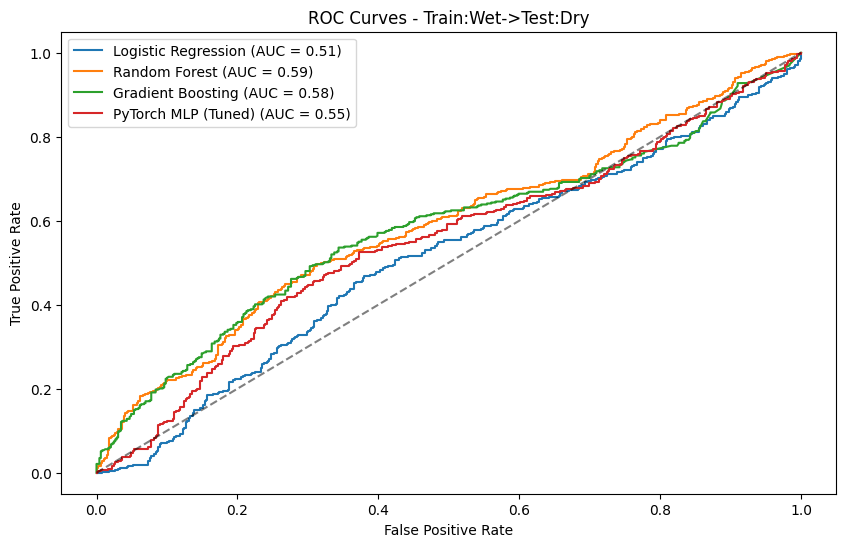


Feature importances (Gradient Boosting):


/tmp/ipython-input-3236858034.py:240: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp, x='Importance', y='Feature', palette='viridis')


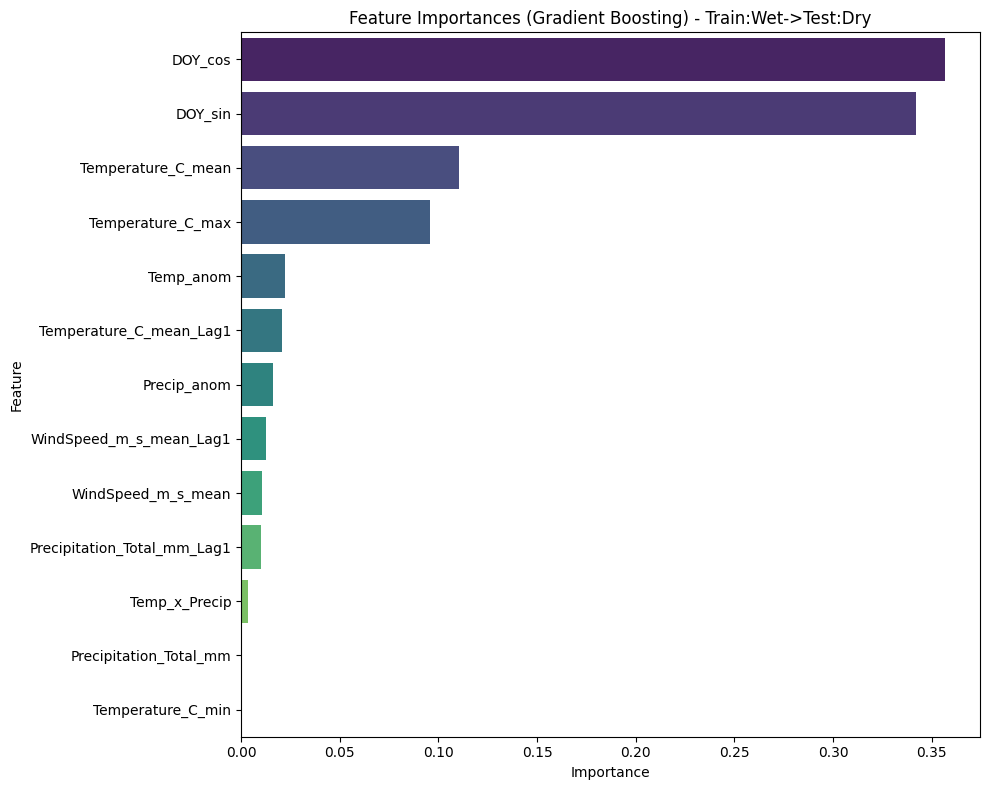


>>> Train on Dry Season -> Test on Wet Season

--- Starting Model Tuning & Training (Train:Dry->Test:Wet) ---

Tuning Logistic Regression...
Best LR Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Tuning Random Forest...
Best RF Params: {'n_estimators': 200, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 20}

Tuning Gradient Boosting...
Best GBM Params: {'subsample': 0.6, 'n_estimators': 100, 'min_samples_leaf': 5, 'max_depth': 2, 'learning_rate': 0.01}
PyTorch Class Weight (pos_weight): 1.14

Starting Hyperparameter Tuning for PyTorch Model...
Best PyTorch Params: {'hidden_layers': [64, 64, 32], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'epochs': 50}
Best PyTorch Validation AUC: 0.6544

Logistic Regression Results:
F1-Score: 0.6809
AUC-ROC: 0.3953

Random Forest Results:
F1-Score: 0.6535
AUC-ROC: 0.5412

Gradient Boosting Results:
F1-Score: 0.6809
AUC-ROC: 0.5394

PyTorch MLP (Tuned) Results:
F1-Score: 0.6809
AUC-ROC: 0.4903


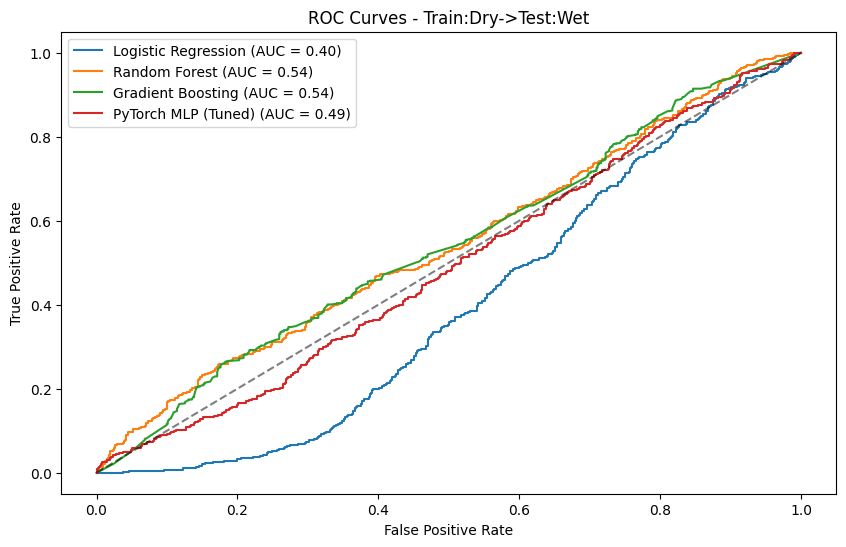


Feature importances (Gradient Boosting):


/tmp/ipython-input-3236858034.py:240: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp, x='Importance', y='Feature', palette='viridis')


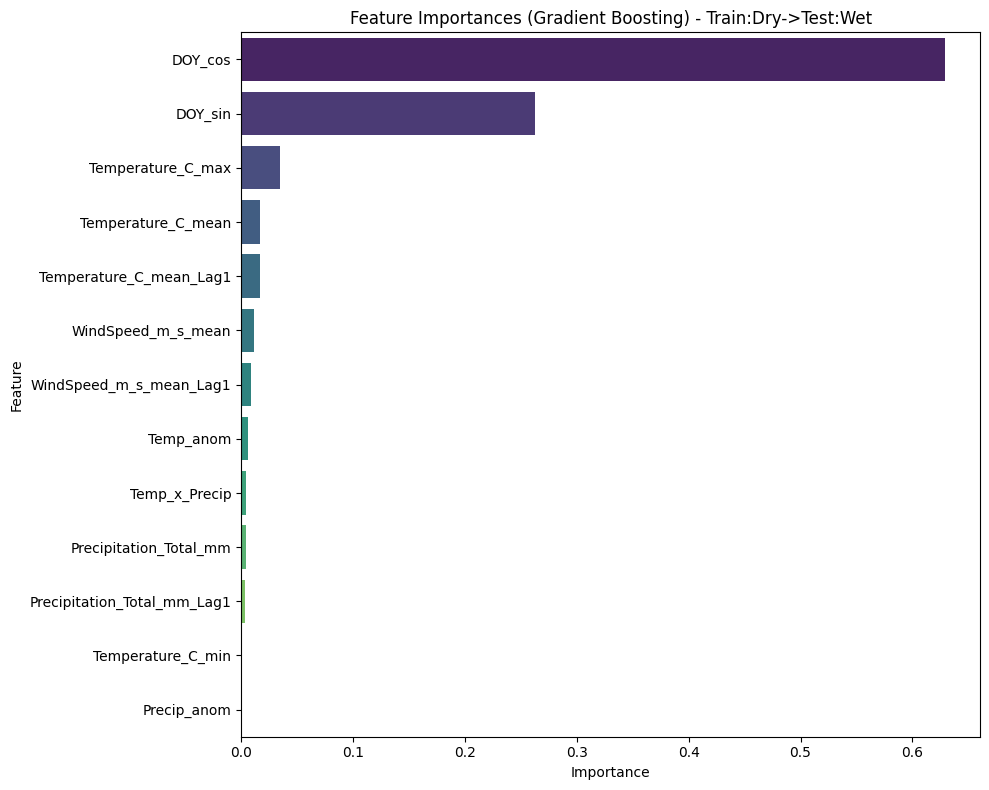


   RUNNING RANDOM SPLIT BASELINE
Train size: 1748, Test size: 437

--- Starting Model Tuning & Training (Random Shuffle) ---

Tuning Logistic Regression...
Best LR Params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

Tuning Random Forest...
Best RF Params: {'n_estimators': 200, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}

Tuning Gradient Boosting...
Best GBM Params: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.05}
PyTorch Class Weight (pos_weight): 0.99

Starting Hyperparameter Tuning for PyTorch Model...
Best PyTorch Params: {'hidden_layers': [128, 64], 'dropout_rate': 0.5, 'learning_rate': 0.01, 'epochs': 100}
Best PyTorch Validation AUC: 0.7780

Logistic Regression Results:
F1-Score: 0.5860
AUC-ROC: 0.6495

Random Forest Results:
F1-Score: 0.7183
AUC-ROC: 0.7869

Gradient Boosting Results:
F1-Score: 0.6501
AUC-ROC: 0.7425

PyTorch MLP (Tuned) Results:
F1-Score: 0.6829
AUC-ROC: 0.7515


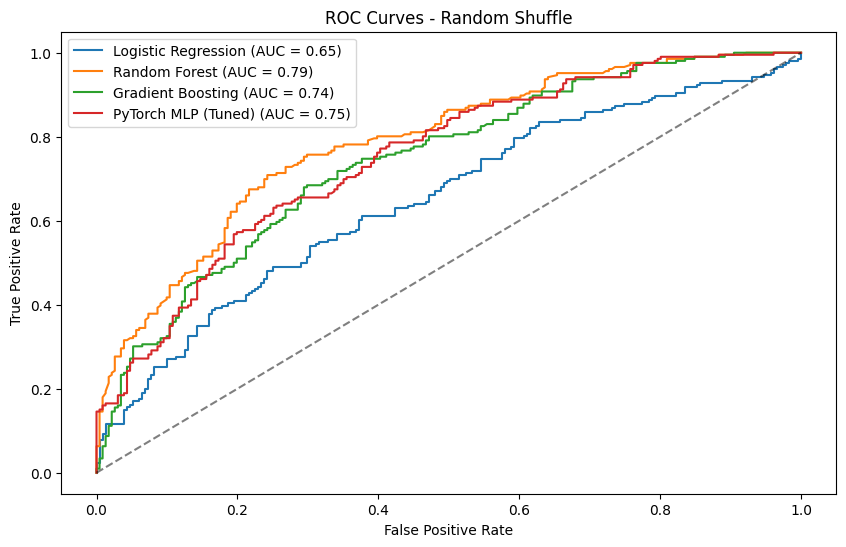


Feature importances (Gradient Boosting):


/tmp/ipython-input-3236858034.py:240: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp, x='Importance', y='Feature', palette='viridis')


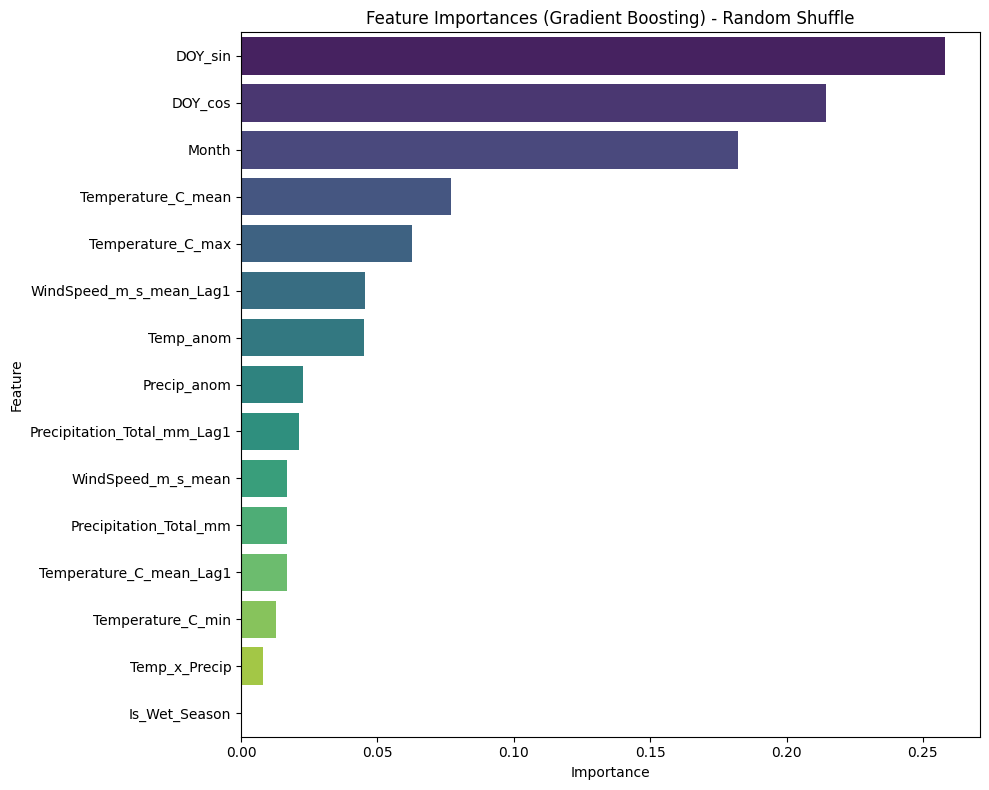

In [ ]:
# Run Seasonal
res_wet_dry, res_dry_wet = run_seasonal_analysis_comprehensive(df_modeled)

# Run Random
res_random = run_random_split_comprehensive(df_modeled)

# Collect Results

all_experiments = {
    'Random Split (Baseline)': res_random,
    'Time-Based Split': model_results,
    'Official Spatial Split': results_official,
    'Seasonal (Wet->Dry)': res_wet_dry,
    'Seasonal (Dry->Wet)': res_dry_wet
}

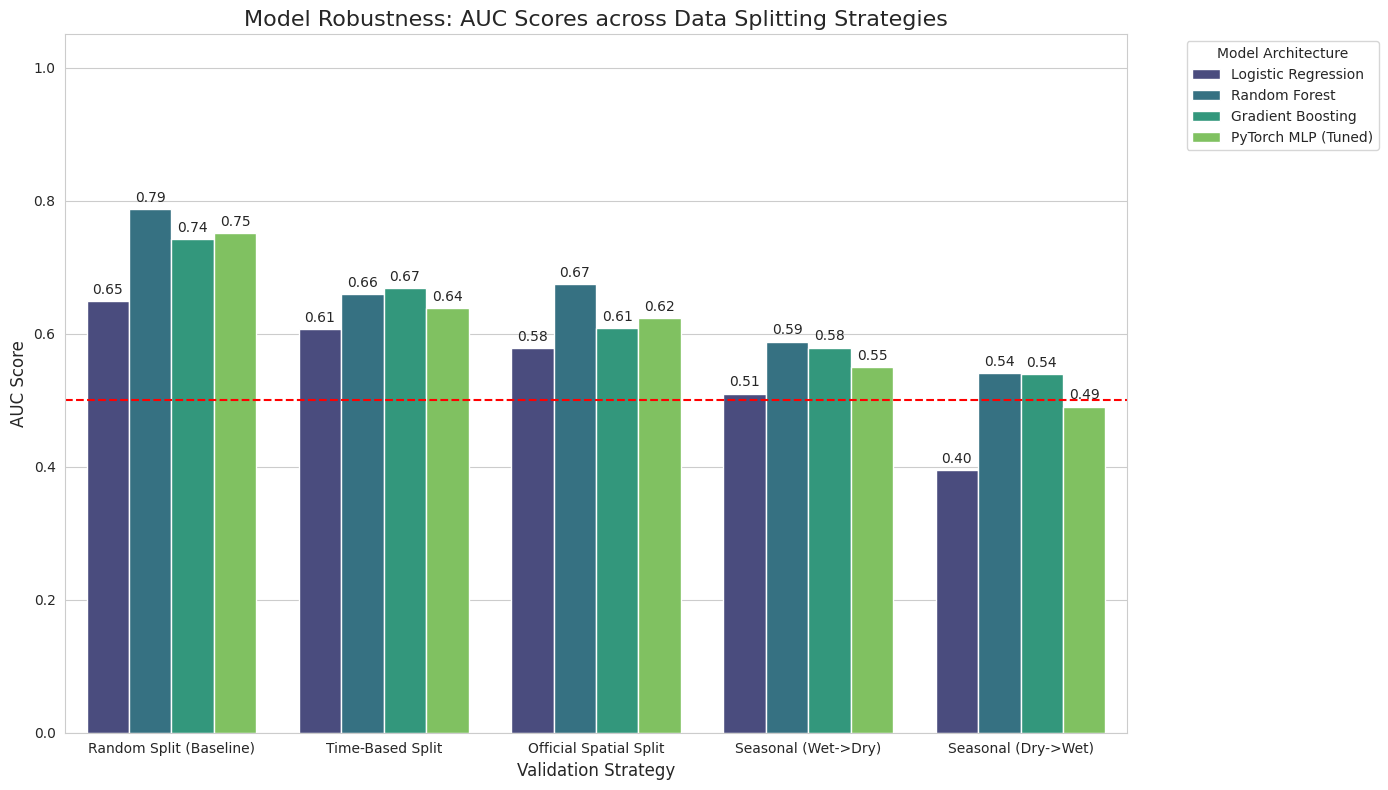

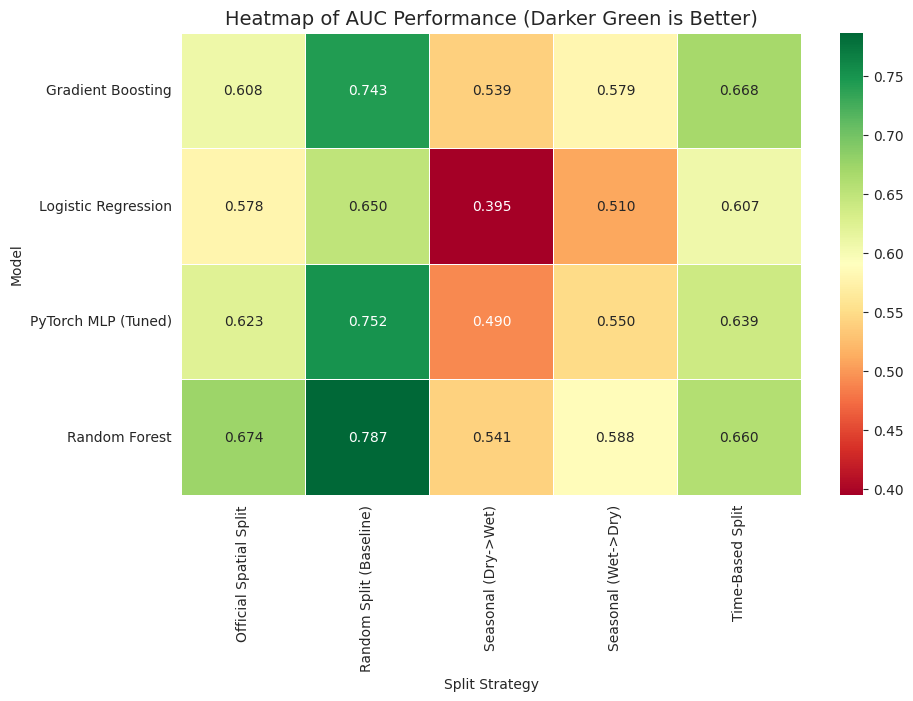

In [ ]:
def plot_comprehensive_comparison(all_experiments):
    records = []
    for split_name, model_dict in all_experiments.items():
        for model_name, metrics in model_dict.items():
            records.append({
                'Split Strategy': split_name,
                'Model': model_name,
                'AUC': metrics['AUC'],
                'F1 Score': metrics['F1']
            })

    df_res = pd.DataFrame(records)

    # Plot AUC Comparison
    plt.figure(figsize=(14, 8))
    sns.set_style("whitegrid")

    # AUC Bar Chart
    chart = sns.barplot(
        data=df_res,
        x='Split Strategy',
        y='AUC',
        hue='Model',
        palette='viridis'
    )

    plt.title('Model Robustness: AUC Scores across Data Splitting Strategies', fontsize=16)
    plt.ylabel('AUC Score', fontsize=12)
    plt.xlabel('Validation Strategy', fontsize=12)
    plt.ylim(0, 1.05)
    plt.legend(title='Model Architecture', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.axhline(y=0.5, color='r', linestyle='--', label='Random Chance')

    # Add value labels
    for container in chart.containers:
        chart.bar_label(container, fmt='%.2f', padding=3)

    plt.tight_layout()
    plt.show()

    # Performance Gap Analysis
    pivot_auc = df_res.pivot(index='Model', columns='Split Strategy', values='AUC')

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_auc, annot=True, cmap='RdYlGn', fmt='.3f', linewidths=.5)
    plt.title('Heatmap of AUC Performance (Darker Green is Better)', fontsize=14)
    plt.show()

if 'all_experiments' in locals():
    plot_comprehensive_comparison(all_experiments)